https://github.com/pytorch/examples/blob/master/mnist/main.py
https://hacks.deeplearning.jp/pytorch%E3%81%AEdataloader/

### モデル

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from collections import OrderedDict

import os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

n_shot = 1
n_class = 10
n_local_update = 5

class OmniglotNet(nn.Module):
    def __init__(self, n_class):
        super(OmniglotNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, n_class)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

    def manual_forward(self, x, params):
        x = F.relu(F.max_pool2d(
            F.conv2d(x, params['conv1.weight'].cuda(), params['conv1.bias'].cuda()), 2))
        x = F.relu(F.max_pool2d(
            F.conv2d(x, params['conv2.weight'].cuda(), params['conv2.bias'].cuda()), 2))
        x = x.view(-1, 320)
        x = F.relu(
            F.linear(x, params['fc1.weight'].cuda(), params['fc1.bias'].cuda()))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(
            F.linear(x, params['fc2.weight'].cuda(), params['fc2.bias'].cuda()), dim=1)
        return x
    
    
def train(model, device, train_data_loader, optimizer, epoch):
    model.train()
    
    for data, target in train_data_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

def test(model, device, test_data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            test_loss += loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    return test_loss, correct / len(test_data_loader.dataset)

### データセット

In [2]:
# inputs: ../omniglot_mini/images_background/Japanese_(hiragana)/
# outputs: {'image': image,'label': label} (1 image)

# check len(label)>=20 before
class OmniglotDataset(Dataset):
    def __init__(self, path_to_lang, n_class, train, train_indices, transform):

        self.data = []
        
        labels = sorted(os.listdir(path_to_lang))[:n_class]
        
        for label_i, label in enumerate(labels):
            path_to_label = os.path.join(path_to_lang, label)
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_indices]
            else:
                test_indices = list(set(np.arange(20)) - set(train_indices)) # 各文字20枚ずつ入ってる
                chars = chars[test_indices]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)
        return [torch.from_numpy(image), torch.from_numpy(label)]

### プロットしてみる

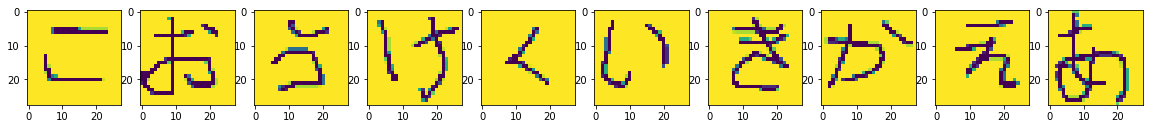

tensor([9, 4, 2, 8, 7, 1, 6, 5, 3, 0])


In [3]:
batch_size = n_class

local_task_train_data_loader = DataLoader(
    OmniglotDataset("../omniglot_mini/images_background/Japanese_(hiragana)/", 
                    n_class=n_class,
                    train=True,
                    train_indices=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

for batch in local_task_train_data_loader:
    plt.figure(figsize=(20,2))
    for i, (image, label) in enumerate(zip(batch[0], batch[1])):
        plt.subplot(1, batch_size, i+1)
        plt.imshow(image[0])
    plt.show()
    print(batch[1])

### 学習 (Omniglot_Japanese-(hiragana), 20classes, 1shot)

In [4]:
batch_size = n_class # batch_size==1だとバグる
lr = 0.01
momentum = 0.5
epochs = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

local_task_train_data_loader = DataLoader(
    OmniglotDataset("../omniglot_mini/images_background/Japanese_(hiragana)/", 
                    n_class=n_class,
                    train=True,
                    train_indices=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

local_task_test_data_loader = DataLoader(
    OmniglotDataset("../omniglot_mini/images_background/Japanese_(hiragana)/", 
                    n_class=n_class,
                    train=False,
                    train_indices=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=20).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

with tqdm(range(1, epochs + 1)) as _tqdm:
    for epoch in _tqdm:
        train(model, device, local_task_train_data_loader, optimizer, epoch)
        temp_loss, temp_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(step=epoch, loss=temp_loss, acc= temp_acc))

 19%|█▊        | 186/1000 [00:02<00:12, 67.21it/s, step=187, loss=2.18, acc=0.305]


KeyboardInterrupt: 

### データセットをMNISTに変えても動く

In [5]:
batch_size = n_class # batch_size==1だとバグる
lr = 0.01
momentum = 0.5
epochs = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
train_data_loader = DataLoader(
    datasets.MNIST('../mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

test_data_loader = DataLoader(
    datasets.MNIST('../mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=n_class).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

with tqdm(range(1, epochs + 1)) as _tqdm:
    for epoch in _tqdm:
        train(model, device, train_data_loader, optimizer, epoch)
        temp_loss, temp_acc = test(model, device, test_data_loader)
        _tqdm.set_postfix(OrderedDict(step=epoch, loss=temp_loss, acc= temp_acc))

100%|██████████| 1/1 [00:11<00:00, 11.37s/it, step=1, loss=0.095, acc=0.969]


### タスクセット

In [5]:
class Taskset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

class TaskLoader(object):
    def __init__(self, taskset, shuffle=True):
        self.taskset = taskset
        self.sample_iter = iter(np.random.permutation(np.arange(len(taskset))))
    def __iter__(self):
        return self
    def __next__(self):
        return self.taskset[next(self.sample_iter)]
    def __len__(self):
        return NotImplementedError

In [6]:
class OmniglotTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_lang = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_lang = os.path.join(path_to_omniglot, "images_evaluation/")
        
        langs = sorted(os.listdir(path_to_lang))
        tasks = [os.path.join(path_to_lang, lang) for lang in langs]
        tasks = [task for task in tasks if len(os.listdir(task))>=n_class]
        self.tasks = tasks
        
    def __len__(self):
        return len(self.tasks)
 
    def __getitem__(self, idx):
        train_indices=[0] #TODO 必要に応じて変える
        return {"train":
                DataLoader(
                    OmniglotDataset(self.tasks[idx], 
                                    n_class=n_class,
                                    train=True,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotDataset(self.tasks[idx],
                                    n_class=n_class,
                                    train=False,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

30
0 ../omniglot_mini/images_background/Mkhedruli_(Georgian)


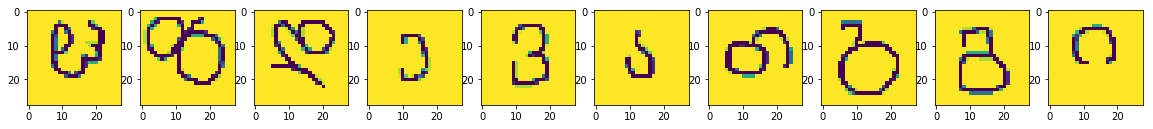

tensor([7, 6, 3, 4, 5, 0, 8, 2, 1, 9])
1 ../omniglot_mini/images_background/Balinese


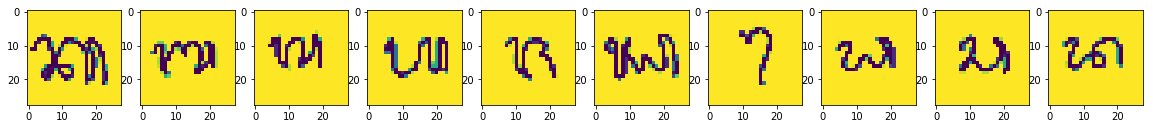

tensor([9, 1, 6, 7, 8, 5, 4, 0, 2, 3])
2 ../omniglot_mini/images_background/Tifinagh


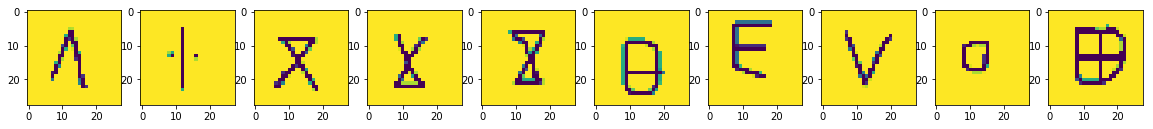

tensor([7, 6, 3, 4, 5, 1, 9, 8, 0, 2])
3 ../omniglot_mini/images_background/Anglo-Saxon_Futhorc


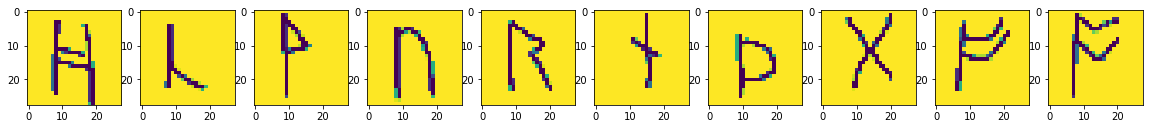

tensor([8, 5, 7, 1, 4, 9, 2, 6, 0, 3])
4 ../omniglot_mini/images_background/Burmese_(Myanmar)


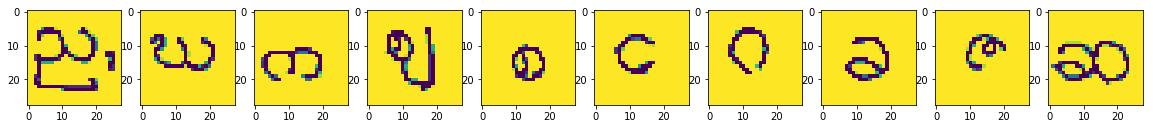

tensor([9, 3, 0, 8, 5, 4, 2, 1, 7, 6])


In [7]:
batch_size = n_class

meta_train_task_loader = TaskLoader(
    OmniglotTaskset("../omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)
print(len(meta_train_task_loader.taskset))
for task_i, meta_train_task in enumerate(meta_train_task_loader):
    print(task_i, meta_train_task["task"])
    local_task_train_data_loader = meta_train_task["train"]
    for batch in local_task_train_data_loader:
        plt.figure(figsize=(20,2))
        for i, (image, label) in enumerate(zip(batch[0], batch[1])):
            plt.subplot(1, batch_size, i+1)
            plt.imshow(image[0]) # image.shape=[1,28,28]
        plt.show()
        print(batch[1])
    if task_i==4:
        break

In [8]:
def train2(model, device, train_data_loader, test_data_loader, optimizer, epoch, stop=1.0):
    model.train()
    
    with tqdm(train_data_loader) as _tqdm:
        for i, (data, target) in enumerate(_tqdm):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if i % 600 == 0:
                temp_loss, temp_acc = test(model, device, test_data_loader)
            _tqdm.set_postfix(OrderedDict(step=epoch, loss=temp_loss, acc= temp_acc))
            if i+1 >= len(train_data_loader)*stop:
                break

### モデルのコピー

### master_model

In [10]:
batch_size = n_class # batch_size==1だとバグる
lr = 0.01
momentum = 0.5
epochs = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
train_data_loader = DataLoader(
    datasets.MNIST('../mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

test_data_loader = DataLoader(
    datasets.MNIST('../mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

master_model = OmniglotNet(n_class=10).to(device)
master_optimizer = optim.SGD(master_model.parameters(), lr=lr, momentum=momentum)

train2(master_model, device, train_data_loader, test_data_loader, master_optimizer, epoch, stop=0.5)

 50%|████▉     | 2988/6000 [00:13<00:13, 218.73it/s, step=1, loss=0.217, acc=0.928]


### 正しく学習が進んでいる

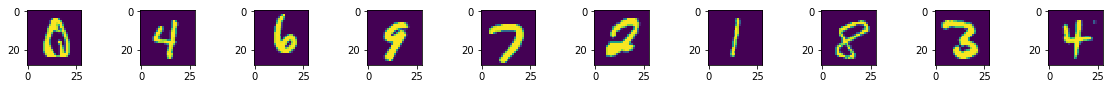

[0 4 6 9 7 2 1 8 3 4]
[0 4 6 9 7 2 1 8 3 4]


In [11]:
for batch_i, (images, labels) in enumerate(test_data_loader):
    plt.figure(figsize=(20,1))
    for i, image in enumerate(images):
        plt.subplot(1, len(images),i+1)
        plt.imshow(image[0])
    plt.show()
    print(labels.detach().numpy())
    y_pred = master_model(images.to(device))
    y_pred = np.argmax(y_pred.cpu().detach().numpy(), 1)
    print(y_pred)
    if batch_i==0:
        break

### faster_model

In [12]:
faster_model = OmniglotNet(n_class=10).to(device)
faster_optimizer = optim.SGD(faster_model.parameters(), lr=lr, momentum=momentum)

### 全く学習していない

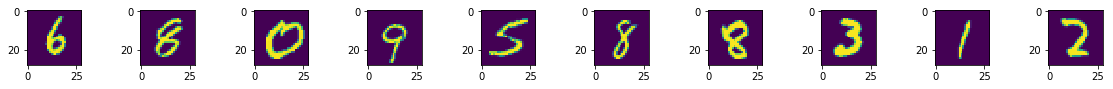

[6 8 0 9 5 8 8 3 1 2]
[5 8 5 8 8 5 8 5 5 8]


In [13]:
for batch_i, (images, labels) in enumerate(test_data_loader):
    plt.figure(figsize=(20,1))
    for i, image in enumerate(images):
        plt.subplot(1, len(images),i+1)
        plt.imshow(image[0])
    plt.show()
    print(labels.detach().numpy())
    y_pred = faster_model(images.to(device))
    y_pred = np.argmax(y_pred.cpu().detach().numpy(), 1)
    print(y_pred)
    if batch_i==0:
        break

### 最終層以外をコピーする（必要なかった）

In [14]:
keys = master_model.state_dict().keys() - set(['fc2.weight', 'fc2.bias'])
print(keys)
params = {k: v for k, v in master_model.state_dict().items() if k in keys}
faster_model.load_state_dict(params, strict=False)

{'conv2.bias', 'fc1.weight', 'conv2.weight', 'conv1.bias', 'conv1.weight', 'fc1.bias'}


### 1epochの20%くらいの時点で96%くらい出る

In [15]:
train2(faster_model, device, train_data_loader, test_data_loader, faster_optimizer, epoch, stop=0.2)

 20%|█▉        | 1190/6000 [00:05<00:22, 214.49it/s, step=1, loss=0.115, acc=0.965]


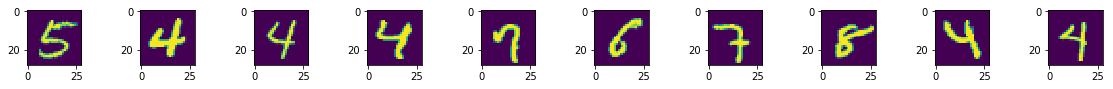

[5 4 4 4 7 6 7 8 4 4]
[5 4 4 4 7 5 7 8 4 4]


In [16]:
for batch_i, (images, labels) in enumerate(test_data_loader):
    plt.figure(figsize=(20,1))
    for i, image in enumerate(images):
        plt.subplot(1, len(images),i+1)
        plt.imshow(image[0])
    plt.show()
    print(labels.detach().numpy())
    y_pred = faster_model(images.to(device))
    y_pred = np.argmax(y_pred.cpu().detach().numpy(), 1)
    print(y_pred)
    if batch_i==0:
        break

---

# MAML

In [13]:
class MetaLearner(object):
    def __init__(self):
        self.lr = 0.01
        self.momentum = 0.5
        self.device = 'cuda'
        self.master_net = OmniglotNet(n_class).to(self.device)
        self.master_opt = optim.Adam(self.master_net.parameters(), lr=0.001)
        self.keys = self.master_net.state_dict().keys()
    
    #TODO need return or not
    def copy_params(self, from_net, to_net):
        params = {k: v for k, v in from_net.state_dict().items() if k in self.keys}
        to_net.load_state_dict(params, strict=False)
    
    def meta_test(self):
        
        meta_test_task_loader = TaskLoader(
            OmniglotTaskset("../omniglot_mini/", meta_train=False, n_class=n_class, n_shot=n_shot))

        loss, acc = [], []
        
        for meta_test_task in meta_test_task_loader:
            
            # copy master model to new branch model
            faster_net = OmniglotNet(n_class).to(self.device)
            self.copy_params(self.master_net, faster_net)
            faster_opt = optim.SGD(faster_net.parameters(), lr=self.lr, momentum=self.momentum)
            
            # make local task data loader
            local_task_train_data_loader = meta_test_task["train"]
            local_task_test_data_loader = meta_test_task["test"]
            
            # train
            for epoch in range(n_local_update):
                train(faster_net, self.device, local_task_train_data_loader, faster_opt, epoch)
            
            # test
            _loss, _acc = test(faster_net, self.device, local_task_test_data_loader)
            loss.append(_loss)
            acc.append(_acc)
            
        print("meta_test_loss: {:.3f}, meta_test_acc: {:.3f}".format(
            np.mean(loss), np.mean(acc)))
    
    def meta_train(self):
        
        meta_train_task_loader = TaskLoader(
            OmniglotTaskset("../omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot))
        
        meta_grads = []
        
        for meta_train_task in meta_train_task_loader:
            
            # copy master model to new branch model
            faster_net = OmniglotNet(n_class).to(self.device)
            self.copy_params(self.master_net, faster_net)
            
            faster_params = OrderedDict((name, param) for (name, param) in faster_net.named_parameters())
            master_params = OrderedDict((name, param) for (name, param) in self.master_net.named_parameters())
        
            # make local task data loader
            local_task_train_data_loader = meta_train_task["train"]
            local_task_test_data_loader = meta_train_task["test"]
            
            # ----------------------------------------------------------------
            # meta train task train
            # ----------------------------------------------------------------
 
            # train n_local_update times / 1 task
            first_train_for_this_task = True
            
            for epoch in range(n_local_update): 
                
                for data, target in local_task_train_data_loader:
                    
                    data, target = data.to(self.device), target.to(self.device)
                    
                    if first_train_for_this_task:
                        # manual predict
                        output = faster_net.manual_forward(data, master_params)
                        loss = F.nll_loss(output, target)

                        # manual optimize
                        grads = torch.autograd.grad(loss, master_params.values(), create_graph=True)
                        
                        first_train_for_this_task = False
                    
                    else:
                        # manual predict
                        output = faster_net.manual_forward(data, faster_params)
                        loss = F.nll_loss(output, target)

                        # manual optimize
                        grads = torch.autograd.grad(loss, faster_params.values(), create_graph=True)
                                                
                    faster_params = OrderedDict(
                        (name, param - self.lr*grad) 
                        for ((name, param), grad) in zip(faster_params.items(), grads)
                    )
                            
            # ----------------------------------------------------------------
            # meta train task test
            # ----------------------------------------------------------------
            
            for data, target in local_task_test_data_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                output = faster_net.manual_forward(data, faster_params)
                loss = F.nll_loss(output, target)

                # manual optimize!!!
                grads = torch.autograd.grad(loss, master_params.values(), create_graph=True)
                
                grads = {name:g for ((name, _), g) in zip(self.master_net.named_parameters(), grads)}
                
                meta_grads.append(grads) # TODO normalize grads by local_task_test_data_size
                                
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct = pred.eq(target.view_as(pred)).sum().item()
            
        # summing up grads
        meta_grads = {k: sum(grads[k] for grads in meta_grads) for k in meta_grads[0].keys()}
        
        dumy_data_loader = DataLoader(
            OmniglotDataset("../omniglot_mini/images_background/Japanese_(hiragana)/", 
                            n_class=n_class,
                            train=True,
                            train_indices=[0],
                            transform=transforms.Compose([
                                ToTensor()
                            ])),
            batch_size=batch_size, shuffle=True)
        
        data, target = dumy_data_loader.__iter__().next()
        data, target = data.to(self.device), target.to(self.device)
        
        output = self.master_net.manual_forward(data, master_params)
        loss = F.nll_loss(output, target)
        
        hooks = []
        for (k,v) in self.master_net.named_parameters():
            def get_closure():
                key = k
                def replace_grad(grad):
                    return meta_grads[key]
                return replace_grad
            hooks.append(v.register_hook(get_closure()))
#         print(hooks)
            
        # Compute grads for current step, replace with summed gradients as defined by hook
        self.master_opt.zero_grad()
        loss.backward()
        print(loss.)
        # Update the net parameters with the accumulated gradient according to optimizer
        self.master_opt.step()
        
        # Remove the hooks before next training phase
        for h in hooks:
            h.remove()

In [ ]:
meta_learner = MetaLearner()

for i in range(100):
    meta_learner.meta_train()
    meta_learner.meta_test()

meta_test_loss: 2.309, meta_test_acc: 0.101
meta_test_loss: 2.316, meta_test_acc: 0.100
meta_test_loss: 2.325, meta_test_acc: 0.098
meta_test_loss: 2.330, meta_test_acc: 0.099
meta_test_loss: 2.334, meta_test_acc: 0.101
meta_test_loss: 2.333, meta_test_acc: 0.097
meta_test_loss: 2.333, meta_test_acc: 0.098
meta_test_loss: 2.325, meta_test_acc: 0.096
meta_test_loss: 2.322, meta_test_acc: 0.095
meta_test_loss: 2.316, meta_test_acc: 0.092
meta_test_loss: 2.312, meta_test_acc: 0.089
meta_test_loss: 2.311, meta_test_acc: 0.095
meta_test_loss: 2.308, meta_test_acc: 0.104
meta_test_loss: 2.308, meta_test_acc: 0.101
meta_test_loss: 2.307, meta_test_acc: 0.097
meta_test_loss: 2.307, meta_test_acc: 0.102
meta_test_loss: 2.306, meta_test_acc: 0.100
meta_test_loss: 2.307, meta_test_acc: 0.098
meta_test_loss: 2.307, meta_test_acc: 0.100
meta_test_loss: 2.307, meta_test_acc: 0.100
meta_test_loss: 2.307, meta_test_acc: 0.100
meta_test_loss: 2.307, meta_test_acc: 0.100
meta_test_loss: 2.307, meta_test